In [5]:
import importlib
import preprocessing
importlib.reload(preprocessing)
from preprocessing import *


In [6]:
#224x224 

In [11]:
BATCH_SIZE=32
IMAGE_SIZE=(64,64)
train_loader,val_loader=create_dataloader(IMAGE_SIZE,batch_size=BATCH_SIZE,data_precentage=0.05)
val_dataset = val_loader.dataset


# Get the datasets
train_dataset = train_loader.dataset
val_dataset = val_loader.dataset

# Print the size of the datasets
print(f"Size of training dataset: {len(train_dataset)}")
print(f"Size of validation dataset: {len(val_dataset)}")

Size of training dataset: 75
Size of validation dataset: 21


In [12]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, inputs, targets):
        # Flatten the tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        # Calculate intersection and union
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice


dice_loss = DiceLoss()

In [13]:
model = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)

Using cache found in /Users/anton_heden/.cache/torch/hub/mateuszbuda_brain-segmentation-pytorch_master


In [14]:
import torch
import train 
importlib.reload(train)
from train import training_loop
import time

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze specific layers (e.g., the last decoder layer)
for param in model.decoder4.parameters():
    param.requires_grad = True

# Define the optimizer and loss function
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=0.01, weight_decay=1e-4)
#
loss_fn= DiceLoss()
star_time=time.time()
unet_metrics=training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs=3)
end_time=time.time()    

print(f"Training time: {end_time-star_time}s")

Starting training
Training on device mps


100%|██████████| 3/3 [00:04<00:00,  1.57s/it]


Epoch 1/3: Train loss: 0.780, Train f1.: 0.220, Train accuracy: 0.905, Val. loss: 0.914, Val. f1.: 0.086 Val. accuracy: 0.817


100%|██████████| 3/3 [00:00<00:00,  3.27it/s]


Epoch 2/3: Train loss: 0.644, Train f1.: 0.356, Train accuracy: 0.903, Val. loss: 0.815, Val. f1.: 0.187 Val. accuracy: 0.802


100%|██████████| 3/3 [00:01<00:00,  2.90it/s]


Epoch 3/3: Train loss: 0.554, Train f1.: 0.448, Train accuracy: 0.923, Val. loss: 0.809, Val. f1.: 0.193 Val. accuracy: 0.855
Training time: 7.8129260540008545s


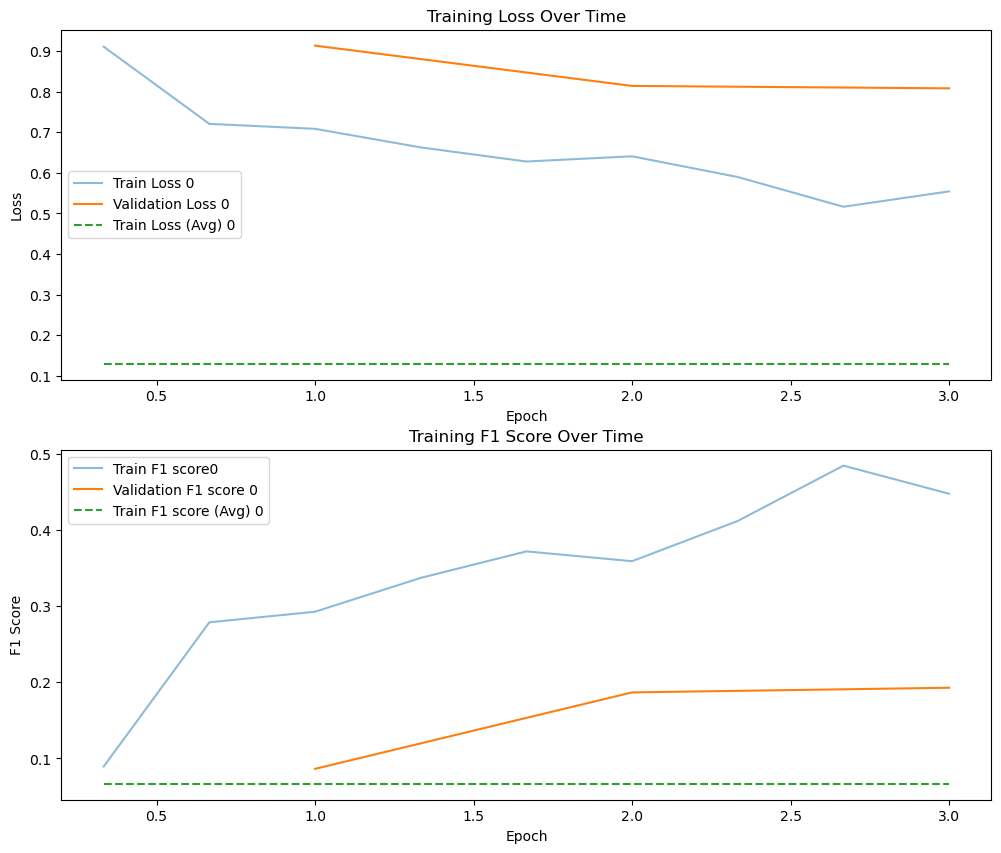

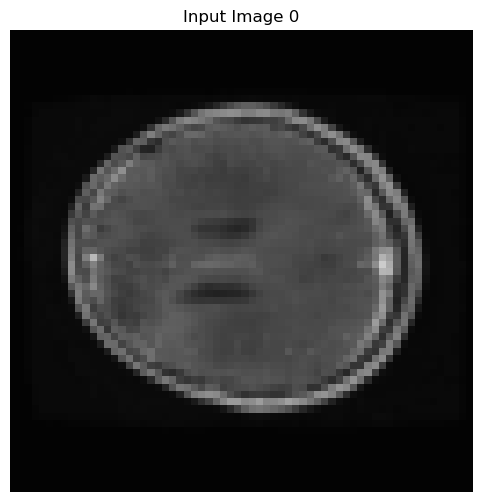

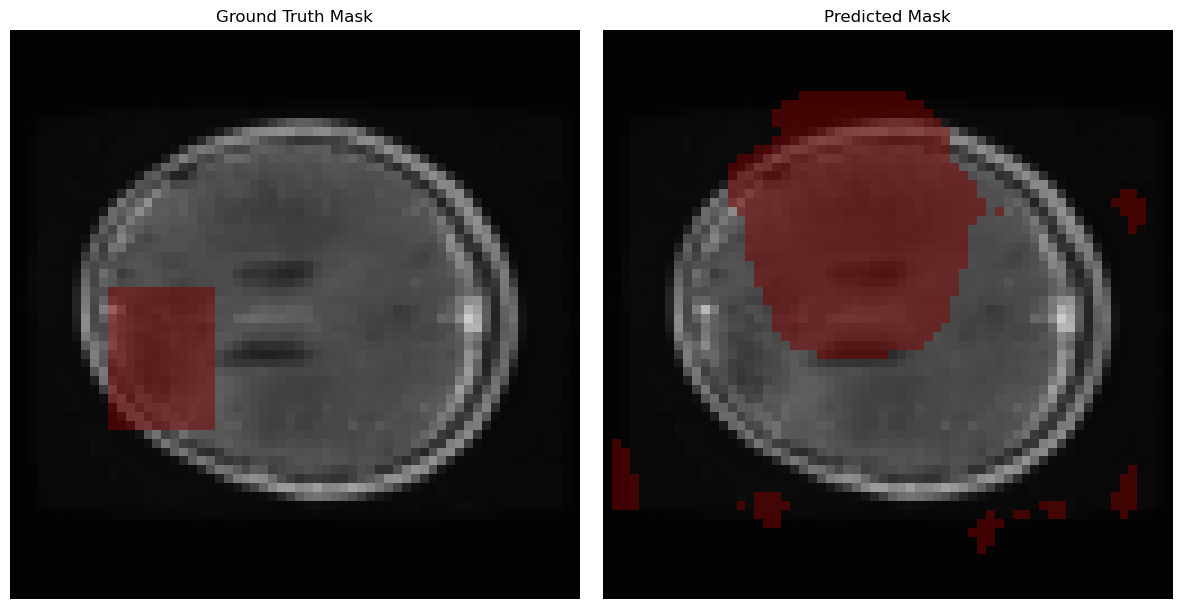

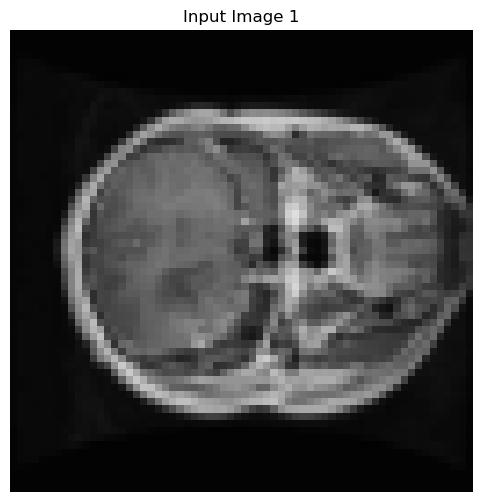

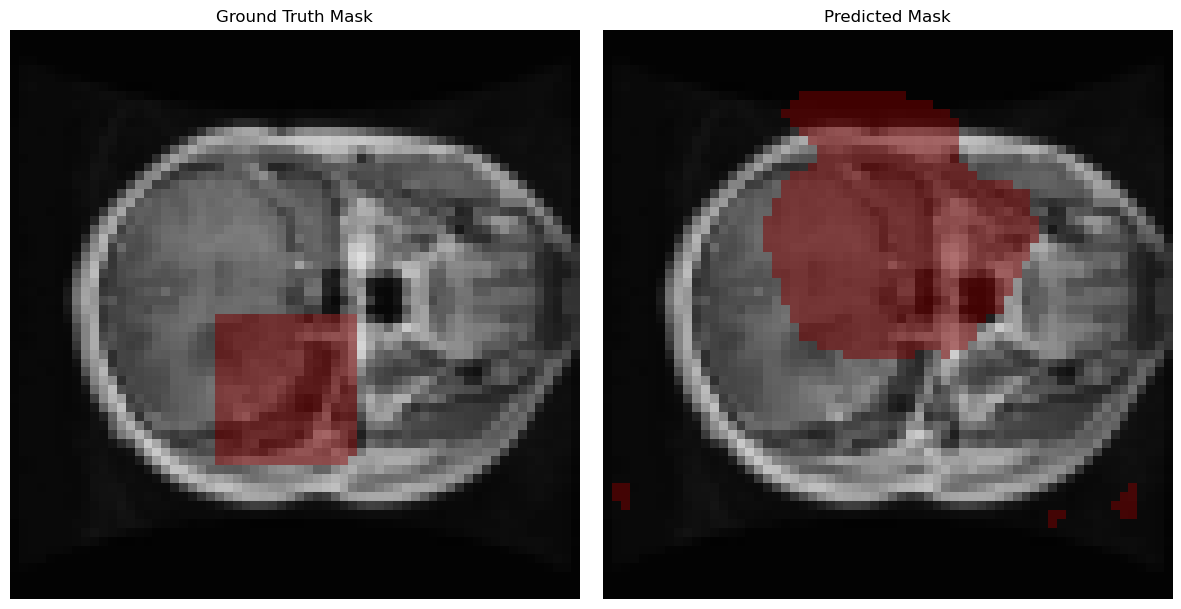

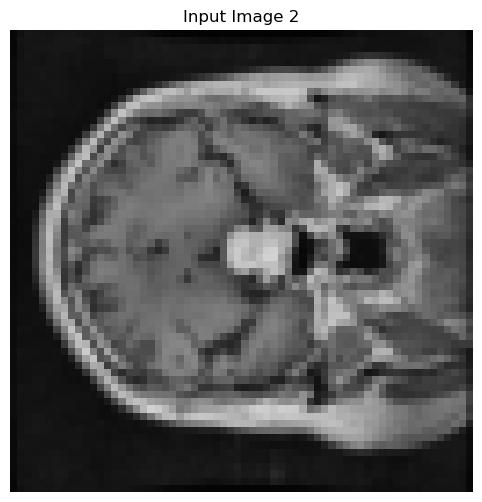

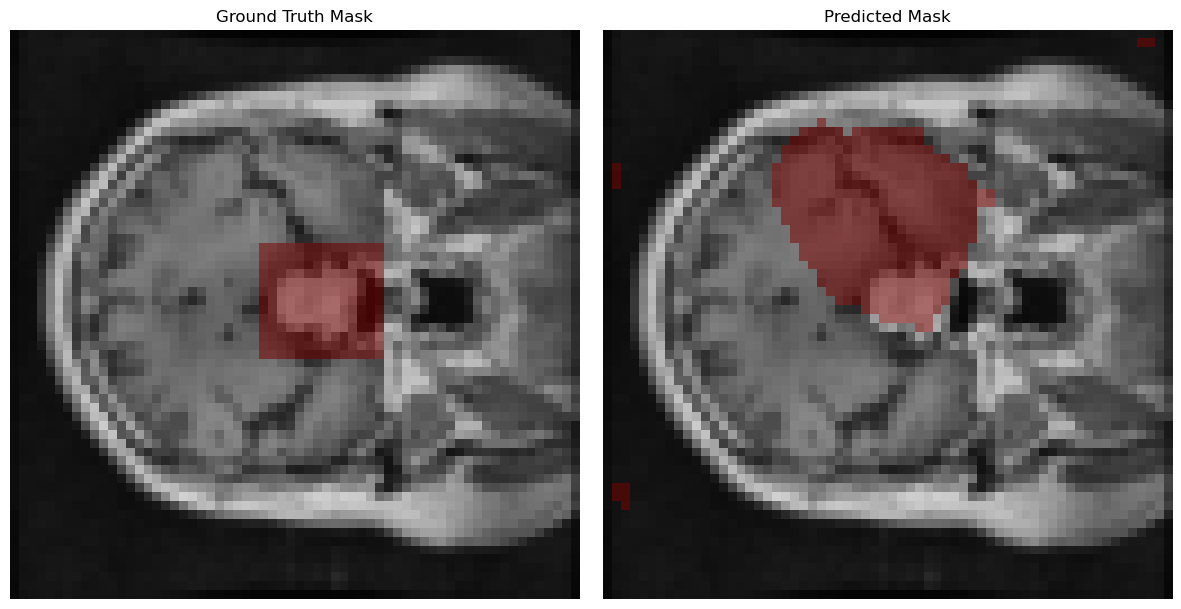

In [18]:
import visualisation
importlib.reload(visualisation)
from visualisation import *


plot_performance_metrics([unet_metrics],batch_size=BATCH_SIZE)
val_dataset = val_loader.dataset


# Plot comparison for a specific index
plot_comparison([0,1,2], val_dataset, unet_metrics[0])

In [91]:
import visualisation
importlib.reload(visualisation)
from visualisation import *
import numpy as np

# Load the model and performance metrics
trained_metrics = get_model_and_performance_metrics("unet_brain2_seg_640.pth", model)
#plot_performance_metrics([trained_metrics],batch_size=16)

# Get the validation dataset
val_dataset = val_loader.dataset


# Plot comparison for a specific index
#Crea list from 20 to 50


plot_comparison([74], val_dataset, model)

ModuleNotFoundError: No module named 'numpy._core'

In [20]:
import train
import preprocessing
importlib.reload(train)
importlib.reload(preprocessing)
from train import predict_and_calc_f1
from preprocessing import *
trained_metrics = get_model_and_performance_metrics("unet_brain_seg.pth", model)
model=trained_metrics[0]
resize_size=(224,224)
transform_mean=[0.485, 0.456, 0.406]
transform_std=[0.229, 0.224, 0.225]
    # Define transformations
image_transform = transforms.Compose([
    transforms.Resize(resize_size),  # Resize images to 256x256
    transforms.ToTensor(),
    transforms.Normalize(mean=transform_mean, std=transform_std)
])

mask_transform = transforms.Compose([
    transforms.Resize(resize_size),  # Resize masks to 256x256
    transforms.ToTensor()
])

# Load COCO annotations for training and validation sets
test_json_path = 'test/_annotations.coco.json'
test_img_dir = 'test'

train_images, train_annotations, train_categories = load_coco_annotations(test_json_path)


# Create datasets and dataloaders
test_dataset = BrainData(train_images, train_annotations, test_img_dir, image_transform=image_transform,mask_transform=mask_transform) 
test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=True)



device = torch.device("cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu"))

#print(predict_and_calc_f1(model, test_dataloader,device))
f1_scores=predict_and_calc_f1(model, test_dataloader,device)
print(np.mean(f1_scores))


100%|██████████| 215/215 [00:10<00:00, 19.65it/s]

0.6157518261704628


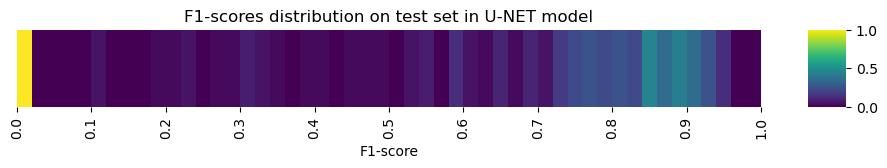

In [111]:

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Create a histogram to represent the density of numbers
hist, bins = np.histogram(f1_scores, bins=50, range=(0, 1))

# Normalize the histogram
hist = hist / hist.max()

# Create a 2D array for the heatmap
heatmap_data = np.tile(hist, (10, 1))

# Create the plot
plt.figure(figsize=(12, 1))  # Wide and low in height
num_ticks = 11
tick_positions = np.linspace(0, heatmap_data.shape[1], num_ticks)
tick_labels = np.linspace(0, 1, num_ticks)


sns.heatmap(heatmap_data, cmap='viridis', cbar=True, xticklabels=True, yticklabels=False,cbar_kws={"shrink": 1, "aspect": 2})
plt.xticks(tick_positions, [f"{label:.1f}" for label in tick_labels])

plt.title('F1-scores distribution on test set in U-NET model')
plt.xlabel('F1-score')
#plt.ylabel('Intensity')
plt.show()